<a href="https://colab.research.google.com/github/chetanvshah20/AddressBook/blob/main/FinalCNN_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Required Package for Split Folder

In [1]:
pip install split-folders

Import Necessary Libraries

In [2]:
import os
import shutil
import splitfolders
import tensorflow as tf
from os import listdir
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, \
                    Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.metrics import Recall, Precision
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
                            classification_report
import pandas as pd
import numpy as np
from sklearn.utils import class_weight
import warnings
warnings.simplefilter(action='ignore')
from PIL import Image
import cv2
import pathlib
import tensorflow_hub as hub
from tensorflow import keras

Get Total Count of Images

In [3]:
images_dirs = pathlib.Path('AutoPort/')
image_count = len(list(images_dirs.glob('*/*.jpg')))
print(image_count)

1162


In [4]:
AutoPort_images_dict = {
    'buoy': list(images_dirs.glob('buoy/*')),
    'cruise_ship': list(images_dirs.glob('cruise_ship/*')),
    'ferry_boat': list(images_dirs.glob('ferry_boat/*')),
    'freight_boat': list(images_dirs.glob('freight_boat/*')),
    'gondola': list(images_dirs.glob('gondola/*')),
    'inflatable_boat': list(images_dirs.glob('inflatable_boat/*')),
    'kayak': list(images_dirs.glob('kayak/*')),
    'paper_boat': list(images_dirs.glob('paper_boat/*')),
    'sailboat': list(images_dirs.glob('sailboat/*')),
}

In [5]:
AutoPort_labels_dict = {
    'buoy': 'buoy 0',
    'cruise_ship': 'cruise_ship 1',
    'ferry_boat': 'ferry_boat 2',
    'freight_boat': 'freight_boat 3',
    'gondola': 'gondola 4',
    'inflatable_boat': 'inflatable_boat 5',
    'kayak': 'kayak 6',
    'paper_boat': 'paper_boat 7',
    'sailboat': 'sailboat 8',
}

# Let's check shape of the input image

In [6]:
img1 = cv2.imread(str(AutoPort_images_dict['buoy'][0]))
img1.shape

(436, 530, 3)

In [7]:
img2 = cv2.imread(str(AutoPort_images_dict['cruise_ship'][0]))
img2.shape

(960, 1280, 3)

In [8]:
img3 = cv2.imread(str(AutoPort_images_dict['ferry_boat'][0]))
img3.shape

(648, 1280, 3)

In [9]:
img4 = cv2.imread(str(AutoPort_images_dict['freight_boat'][0]))
img4.shape

(853, 1280, 3)

In [10]:
img6 = cv2.imread(str(AutoPort_images_dict['gondola'][0]))
img6.shape

(960, 1280, 3)

In [11]:
img7 = cv2.imread(str(AutoPort_images_dict['inflatable_boat'][0]))
img7.shape

(960, 1280, 3)

In [12]:
img8 = cv2.imread(str(AutoPort_images_dict['kayak'][0]))
img8.shape

(796, 1280, 3)

In [13]:
img9 = cv2.imread(str(AutoPort_images_dict['paper_boat'][0]))
img9.shape

(853, 1280, 3)

In [14]:
img10 = cv2.imread(str(AutoPort_images_dict['sailboat'][0]))
img10.shape

(960, 1280, 3)

# ReSize All Image

In [15]:
X, y = [], []

for flower_name, images in AutoPort_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(299,299))
        X.append(resized_img)
        y.append(AutoPort_labels_dict[flower_name])

In [16]:
import numpy as np

X = np.array(X)
y = np.array(y)

#splitting input data into train and test set

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43)

In [18]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [19]:
X[0].shape

(299, 299, 3)

In [20]:
X_train_scaled[0].shape

(299, 299, 3)

In [21]:
tf.random.set_seed(1)

train_datagen = \
    ImageDataGenerator(preprocessing_function = \
                       tf.keras.applications.mobilenet.preprocess_input, \
                       rotation_range=20, \
                       width_shift_range=0.2, \
                       height_shift_range=0.2, \
                       shear_range=0.2, \
                       zoom_range=0.2, \
                       horizontal_flip=True, \
                       fill_mode='nearest')
train_generator = \
    train_datagen.flow_from_directory(\
        'AutoPort',\
        target_size=(224, 224),\
        batch_size=32,\
        classes=['ferry_boat', 'gondola', 'sailboat', 'cruise_ship', 'kayak', \
                 'inflatable_boat', 'paper_boat', 'buoy', 'freight_boat'], \
        class_mode='categorical',\
        shuffle=True)

Found 1162 images belonging to 9 classes.


In [22]:
test_datagen = \
    ImageDataGenerator(preprocessing_function = \
                       tf.keras.applications.mobilenet.preprocess_input)
test_generator = \
    test_datagen.flow_from_directory(\
        'AutoPort',\
        target_size=(224, 224),\
        batch_size=32,\
        classes=['ferry_boat', 'gondola', 'sailboat', 'cruise_ship', 'kayak', \
                 'inflatable_boat', 'paper_boat', 'buoy', 'freight_boat'], \
        class_mode='categorical', \
        shuffle=True)

Found 1162 images belonging to 9 classes.


In [23]:
val_datagen = \
    ImageDataGenerator(preprocessing_function = \
                       tf.keras.applications.mobilenet.preprocess_input)
validation_generator = \
    val_datagen.flow_from_directory(\
        'AutoPort',\
        target_size=(224, 224),\
        batch_size=32,\
        classes=['ferry_boat', 'gondola', 'sailboat', 'cruise_ship', 'kayak',\
                 'inflatable_boat', 'paper_boat', 'buoy', 'freight_boat'],\
        class_mode='categorical',\
        shuffle=True)

Found 1162 images belonging to 9 classes.


# Create object for MobileNet

In [24]:
base_model = MobileNet(weights='imagenet', include_top=False)

In [25]:
average_pooling_layer = GlobalAveragePooling2D()(base_model.output)
dropout_layer_1 = Dropout(rate=0.2)(average_pooling_layer)
hidden_layer_1 = Dense(256, activation='relu')(dropout_layer_1)
normalization_layer_1 = BatchNormalization()(hidden_layer_1)
dropout_layer_2 = Dropout(rate=0.1)(normalization_layer_1)
hidden_layer_2 = Dense(128, activation='relu')(dropout_layer_2)
normalization_layer_2 = BatchNormalization()(hidden_layer_2)
dropout_layer_3 = Dropout(rate=0.1)(normalization_layer_2)
predictions = Dense(9, activation='softmax')(dropout_layer_3)

In [26]:
model = Model(inputs=base_model.input, outputs=predictions)

In [27]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, None, None, 32)      │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, None, None, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, None, None, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, None, None, 32)      │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, None, None, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, None, None, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, None, None, 64)      │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, None, None, 64)      │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, None, None, 64)      │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, None, None, 64)      │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, None, None, 128)     │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, None, None, 128)     │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, None, None, 128)     │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, None, None, 128)     │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, None, None, 128)     │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,526,857 (13.45 MB)

 Trainable params: 3,504,201 (13.37 MB)

 Non-trainable params: 22,656 (88.50 KB)

In [28]:
Model: "functional_1"

In [29]:
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)

In [30]:
weights = \
    class_weight.compute_class_weight(\
        'balanced', \
        classes=np.unique(train_generator.classes),
        y=train_generator.classes)
class_weights = dict(enumerate(weights))

In [31]:
model.compile(optimizer=Adam(learning_rate=0.0001), \
              loss='categorical_crossentropy', \
              metrics=['accuracy',Precision(),Recall()])

In [32]:
history = model.fit(train_generator, \
                    steps_per_epoch = train_generator.samples // 32, \
                    validation_data = validation_generator, \
                    validation_steps = validation_generator.samples // 32,\
                    callbacks=[early_stopping_cb],\
                    class_weight=class_weights,\
                    epochs = 50)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 320s 8s/step - accuracy: 0.1644 - loss: 2.6425 - precision: 0.2190 - recall: 0.0749 - val_accuracy: 0.3576 - val_loss: 2.0357 - val_precision: 0.5500 - val_recall: 0.0859
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.2500 - loss: 2.1462 - precision: 0.3000 - recall: 0.0938 - val_accuracy: 0.4000 - val_loss: 2.3416 - val_precision: 0.3333 - val_recall: 0.1000
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 295s 8s/step - accuracy: 0.3276 - loss: 1.7768 - precision: 0.4342 - recall: 0.1810 - val_accuracy: 0.5417 - val_loss: 1.3421 - val_precision: 0.8138 - val_recall: 0.2769
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.4062 - loss: 1.3565 - precision: 0.5556 - recall: 0.3125 - val_accuracy: 0.5000 - val_loss: 1.5280 - val_precision: 1.0000 - val_recall: 0.2000
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 310s 8s/step - accuracy: 0.4522 - loss: 1.3785 - precision: 0.6079 - recall: 0.2994 - val_accuracy: 0.6944 - val_loss: 0.9739 

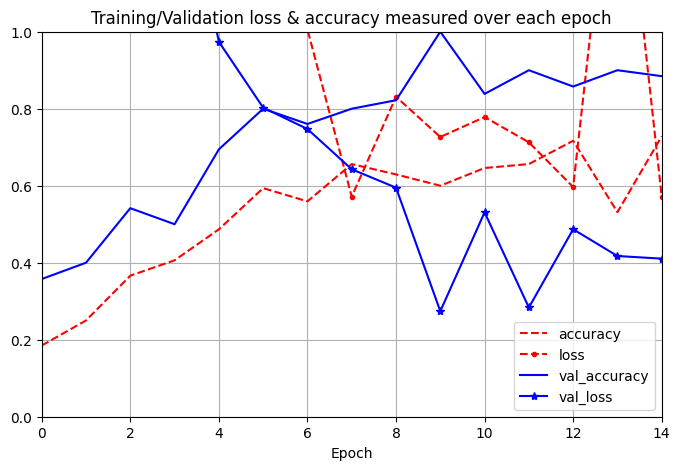

In [33]:
history_df = pd.DataFrame(history.history)
history_df.drop(['precision','recall', 'val_precision','val_recall'],\
                axis=1,inplace=True)
history_df.plot(
    figsize=(8, 5), xlim=[0, early_stopping_cb.stopped_epoch], ylim=[0, 1], \
    grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower right")
plt.title('Training/Validation loss & accuracy measured over each epoch')
plt.show()

In [34]:
test_loss, test_acc, test_precision, test_recall = \
    model.evaluate(test_generator, steps=test_generator.samples // 32)
print('Metrics obtained on test images')
print(f'Accuracy: {test_acc}, Loss: {test_loss}, ' +\
      f'Precision: {test_precision}, Recall: {test_recall}')

36/36 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8190 - loss: 0.6141 - precision: 0.9041 - recall: 0.7022
Metrics obtained on test images
Accuracy: 0.8229166865348816, Loss: 0.5918793678283691, Precision: 0.9084821343421936, Recall: 0.7065972089767456


In [35]:
y_test_proba = model.predict(test_generator)
y_test_pred = np.argmax(y_test_proba, axis=1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step


In [36]:
y_test = test_generator.classes
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.09      0.10      0.09        63
           1       0.18      0.17      0.17       193
           2       0.34      0.29      0.31       389
           3       0.17      0.14      0.15       191
           4       0.18      0.15      0.16       203
           5       0.00      0.00      0.00        16
           6       0.00      0.00      0.00        31
           7       0.03      0.08      0.04        53
           8       0.02      0.04      0.03        23

    accuracy                           0.19      1162
   macro avg       0.11      0.11      0.11      1162
weighted avg       0.21      0.19      0.20      1162



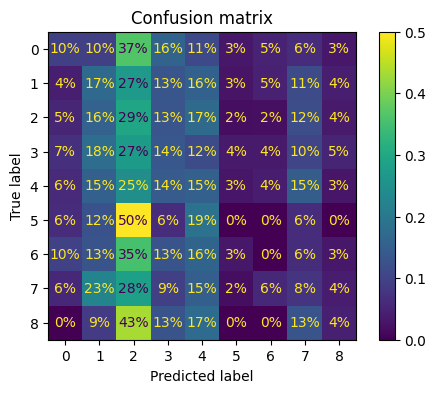

In [37]:
f, ax = plt.subplots(figsize=(6, 4))
ConfusionMatrixDisplay.from_predictions(y_test, \
                                        y_test_pred, \
                                        ax = ax, \
                                        normalize='true', \
                                        values_format='.0%')
plt.title(f'Confusion matrix')
plt.show()

In [38]:
tf.random.set_seed(43)

train_datagen_1 = \
    ImageDataGenerator(preprocessing_function = \
                       tf.keras.applications.mobilenet.preprocess_input, \
                       rotation_range=20, \
                       width_shift_range=0.2, \
                       height_shift_range=0.2, \
                       shear_range=0.2, \
                       zoom_range=0.2, \
                       horizontal_flip=True, \
                       fill_mode='nearest')
train_generator_1 = \
    train_datagen_1.flow_from_directory(\
        'AutoPort',\
        target_size=(224, 224),\
        batch_size=32,\
        classes=['ferry_boat', 'gondola', 'sailboat', 'cruise_ship', 'kayak', \
                 'inflatable_boat', 'paper_boat', 'buoy', 'freight_boat'], \
        class_mode='categorical',\
        shuffle=True)

val_datagen_1 = \
    ImageDataGenerator(preprocessing_function = \
                       tf.keras.applications.mobilenet.preprocess_input)
validation_generator_1 = \
    val_datagen_1.flow_from_directory(\
        'AutoPort',\
        target_size=(224, 224),\
        batch_size=32,\
        classes=['ferry_boat', 'gondola', 'sailboat', 'cruise_ship', 'kayak',\
                 'inflatable_boat', 'paper_boat', 'buoy', 'freight_boat'],\
        class_mode='categorical',\
        shuffle=True)

test_datagen_1 = \
    ImageDataGenerator(preprocessing_function = \
                       tf.keras.applications.mobilenet.preprocess_input)
test_generator_1 = \
    test_datagen_1.flow_from_directory(\
        'AutoPort',\
        target_size=(224, 224),\
        batch_size=32,\
        classes=['ferry_boat', 'gondola', 'sailboat', 'cruise_ship', 'kayak',\
                 'inflatable_boat', 'paper_boat', 'buoy', 'freight_boat'], \
        class_mode='categorical', \
        shuffle=True)

Found 1162 images belonging to 9 classes.
Found 1162 images belonging to 9 classes.
Found 1162 images belonging to 9 classes.


In [39]:
model_1 = Sequential()

# Add the first Conv2D and MaxPool2D layers
model_1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Add the second Conv2D and MaxPool2D layers
model_1.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))

# Add the GlobalAveragePooling2D layer
model_1.add(GlobalAveragePooling2D())

# Add the first Dense layer
model_1.add(Dense(128, activation='relu'))

# Add the second Dense layer
model_1.add(Dense(128, activation='relu'))

# Add the output layer
model_1.add(Dense(9, activation='softmax'))

In [40]:
model_1.summary()
Model: "sequential"

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 111, 111, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 55, 55, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,041 (125.16 KB)

 Trainable params: 32,041 (125.16 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
early_stopping_cb_1 = EarlyStopping(patience=5, restore_best_weights=True)

In [42]:
weights1 = \
    class_weight.compute_class_weight('balanced',\
                                      classes=\
                                      np.unique(train_generator_1.classes), \
                                      y=train_generator_1.classes)
class_weights1 = dict(enumerate(weights1))

In [43]:
model_1.compile(optimizer=Adam(learning_rate=0.0001), \
                loss='categorical_crossentropy', \
                metrics=['accuracy',Precision(),Recall()])

In [44]:
history_1 = model_1.fit(train_generator_1, \
                        steps_per_epoch = train_generator_1.samples // 32, \
                        validation_data = validation_generator_1, \
                        validation_steps = \
                            validation_generator_1.samples // 32, \
                        callbacks=[early_stopping_cb_1], \
                        class_weight=class_weights1 , \
                        epochs = 20)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step - accuracy: 0.0753 - loss: 2.2648 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.0703 - val_loss: 2.1958 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1250 - loss: 2.8678 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.2000 - val_loss: 2.1963 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - accuracy: 0.1024 - loss: 2.1373 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.1311 - val_loss: 2.1886 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 376ms/step - accuracy: 0.0625 - loss: 2.3298 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 2.1825 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 

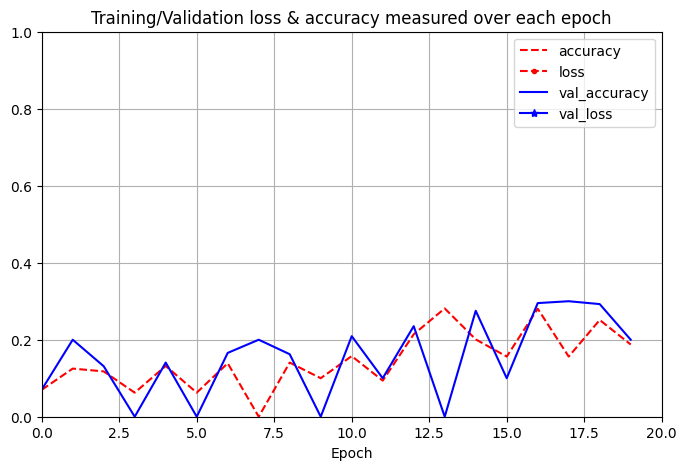

In [45]:
history_df1 = pd.DataFrame(history_1.history)
history_df1.drop(['precision_1','recall_1', 'val_precision_1','val_recall_1'],\
                 axis=1,inplace=True)
history_df1.plot(
    figsize=(8, 5), xlim=[0, 20], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="upper right")
plt.title('Training/Validation loss & accuracy measured over each epoch')
plt.show()

In [46]:
test_loss1, test_acc1, test_precision1, test_recall1 = \
    model_1.evaluate(test_generator_1, steps=test_generator_1.samples // 32)
print('Metrics obtained on test images')
print(f'Accuracy: {test_acc1}, Loss: {test_loss1}, ' +\
      f'Precision: {test_precision1}, Recall: {test_recall1}')

36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 758ms/step - accuracy: 0.2920 - loss: 2.1145 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Metrics obtained on test images
Accuracy: 0.2925347089767456, Loss: 2.1137373447418213, Precision: 0.0, Recall: 0.0


In [47]:
y_test_proba1 = model_1.predict(test_generator_1)
y_test_pred1 = np.argmax(y_test_proba1, axis=1)

37/37 ━━━━━━━━━━━━━━━━━━━━ 27s 712ms/step


In [48]:
y_test1 = test_generator_1.classes
print(classification_report(y_test1, y_test_pred1))

              precision    recall  f1-score   support

           0       0.03      0.02      0.02        63
           1       0.16      0.59      0.26       193
           2       0.32      0.25      0.28       389
           3       0.00      0.00      0.00       191
           4       0.00      0.00      0.00       203
           5       0.00      0.00      0.00        16
           6       0.03      0.06      0.04        31
           7       0.06      0.02      0.03        53
           8       0.00      0.00      0.00        23

    accuracy                           0.19      1162
   macro avg       0.07      0.10      0.07      1162
weighted avg       0.14      0.19      0.14      1162



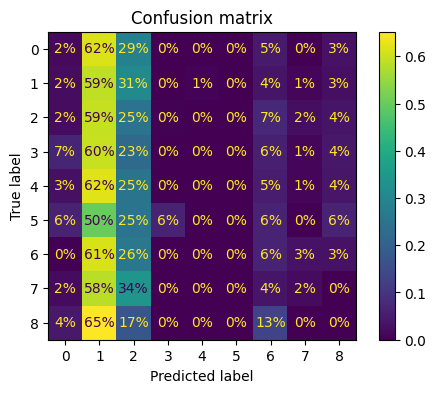

In [49]:
f, ax = plt.subplots(figsize=(6, 4))
ConfusionMatrixDisplay.from_predictions(y_test1, \
                                        y_test_pred1, \
                                        ax = ax, \
                                        normalize='true', \
                                        values_format='.0%')
plt.title(f'Confusion matrix')
plt.show()

# Conclusions

We created two models.

A model baased on MobileNet with top layers replaced
A full custom model
 The accuracy obtained with a full custom model is much lower than that obtained with MobileNet pre-trained model. For automating port operations, the MobileNet custom model can be used and produces much better results.